# Segmentation

Learning to find the optimal parameters s.t. $x(\theta) = \min_x \alpha||Dx||_\epsilon + h(x) - \langle x, n(\theta, y)\rangle$ is a good segmentation.

$n(\theta,\cdot)$ is a learnable mapping and $D$ is a learnable operator (or fixed to a finite diff' operator)

## Imports:

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt

import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as go
ply.offline.init_notebook_mode(connected=True)
import plotly.io as pio

import os
import time
from collections import defaultdict
from copy import deepcopy


from IPython.display import clear_output
%load_ext autoreload

from PIL import Image
import bilevelsurrogates as Sur

#ymmv:
torch.backends.cudnn.benchmark = True
import pickle

### GPU Setup:


In [2]:
### GPU Setup:
device = torch.device('cpu')
dtype = torch.float
#Sur.deterministic()

batch_size = 4
m, n = 128, 256
c = 19

## Data Generation:

In [55]:
def label_to_layer(label_img):
    label_img = tt.functional.to_tensor(label_img)*255
    label_img = Sur.data.CityscapesSemantic.encode_segmap(label_img)
    label_layer = torch.zeros(c, m, n, dtype=torch.uint8)
    for channel in range(c):
        label_layer[channel, :, :] = (label_img[0,:,:]==channel)
    return label_layer

def decode_img(layers, valid_pixels=None):
    labels = layers.argmax(dim=0)
    labels = Sur.data.CityscapesSemantic.decode_segmap(labels.cpu().numpy())
    if valid_pixels is not None:
        mask = 1-valid_pixels.to(dtype=torch.long).unsqueeze(2).expand(-1, -1, 3).cpu().numpy()
        np.putmask(labels, mask, np.ones_like(labels))
    return labels

In [56]:
path = os.path.dirname(os.getcwd()) + '/data/cityscapes_data' 

transforms_img = tt.Compose([tt.Resize([m, n], Image.BILINEAR), tt.ToTensor()]) 
transforms_target = tt.Compose([tt.Resize([m, n], Image.NEAREST),
                               label_to_layer]) 
dataset = torchvision.datasets.Cityscapes(path, split='val', mode='fine', target_type='semantic',
                                               transform=transforms_img, target_transform=transforms_target)

In [57]:
samples = Sur.data.Samples(dataset, batch_size, device=device, dtype=dtype, notation='(y,x)', shuffle=False)

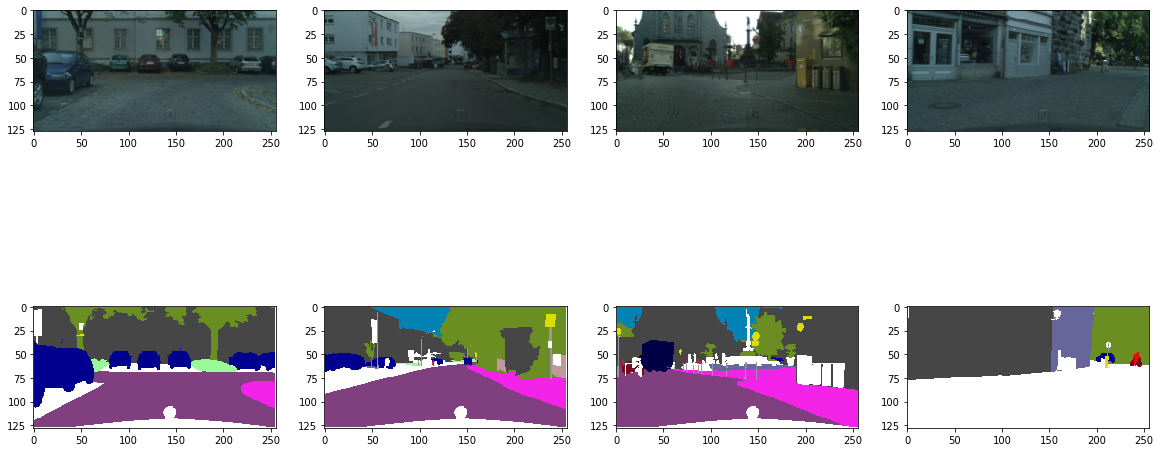

In [58]:
fig, axes = plt.subplots(2,4,figsize=(20, 10))
for i in range(4):
    layers, img = samples.x, samples.y
    axes[0, i].imshow(img[i, :, :, :].permute(1,2,0).cpu().numpy())
    axes[1, i].imshow(decode_img(layers[i,:,:],layers[i,:,:].sum(0)))
fig.canvas.draw()

# Define Energy Model

In [59]:
model_setup = dict()
model_setup['data'] = dict(dtype=dtype, device=device)

# Sizes:
model_setup['x_dims'] = samples.x.shape

# Hyperparameters:
model_setup['alpha'] = 0.0
model_setup['epsilon'] = 0.0
model_setup['bias'] = True
model_setup['norm'] = 'iso2'
model_setup['only_valid'] = True

model_setup['inference'] = dict(tolerance=1e-4, max_iterations=1000)

# Define Model
def energy_setup(model_setup):
    dictionary = Sur.Convolution(in_channels=3, out_channels=c, kernel_size=3,
                                 bias=model_setup['bias']).to(**model_setup['data'])
    torch.nn.init.orthogonal_(dictionary.weight, gain=1)
    energy = Sur.model.Segmentation(dictionary, model_setup)
    energy.prepare_training(samples.x, samples.y)
    return energy
energy = energy_setup(model_setup)

# Define Higher-level Loss

In [116]:
loss = Sur.loss.ClassificationLoss(valid_pixels=energy.valid_pixels)

In [9]:
def training_error(energy, samples):
    timer = time.time()
    output = energy.minimize(samples.y)
    val, val_n, val_f = loss(samples.x, output)
    metric, metric_n, metric_f = loss.metric(samples.x, output)
    m, s = divmod(time.time()-timer, 60)
    print(f'TRAINING | {val_n}: {val:{val_f}} | {metric_n} for these samples: {metric:{metric_f}}%, '
          f' Time: {m:02.0f}:{s:02.0f} mins')
    return output, metric

def metric_error(energy, samples):
    timer = time.time()
    output = energy.test_minimize(samples.y)
    metric, metric_n, metric_f = loss.metric(samples.x, output, labels_given=True)
    m, s = divmod(time.time()-timer, 60)
    print(f'TRAINEVAL| --------------   | {metric_n} for these samples: {metric:{metric_f}}%, '
          f' Time: {m:02.0f}:{s:02.0f} mins')
    return output, metric

**Old Results:**

Cent average: 0.6194834327945901

Cent + TV average: 0.6208809679531911

Surrogate potential average: 0.6209142162989211

Surrogate average: 0.6377361950462903

Surrogate neg-entropy average: 0.6351149858220977


# Baseline (setting alpha = 0)

In [10]:
training_setup = Sur.training.default_setup('DiscriminativeLearning')
training_setup['lr'] = 0.01
training_setup['max_iterations'] = 8_000
algorithm = 'joint-dual'

In [11]:
energy = energy_setup(model_setup)
optimizer_baseline = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm)
optimizer_baseline.run();

status: iteration    0, loss: 3.16852 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 1.37302 (acc est: 53.37%), tol: 0.003%
status: iteration 2000, loss: 1.35245 (acc est: 54.07%), tol: 0.001%
status: iteration 3000, loss: 1.34473 (acc est: 54.33%), tol: 0.001%
status: iteration 4000, loss: 1.33930 (acc est: 54.51%), tol: 0.000%
status: iteration 5000, loss: 1.33556 (acc est: 54.64%), tol: 0.000%
status: finished  5222  iterations in 21 minutes and 23.45 seconds. tol: 0.000%


In [12]:
output, _ = training_error(energy, samples);
_, _ = metric_error(energy, samples);

TRAINING | NLLloss: 1.33493 | acc  for these samples: 50.36%%,  Time: 00:00 mins
TRAINEVAL| --------------   | acc  for these samples: 50.36%%,  Time: 00:00 mins


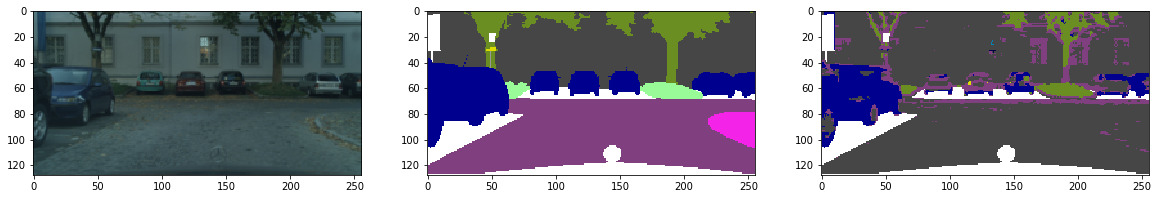

In [13]:
idx = 0
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(samples.y[idx,:,:].permute(1,2,0).cpu().numpy())
axes[1].imshow(decode_img(samples.x[idx,:,:], energy.valid_pixels[idx,:,:]))
axes[2].imshow(decode_img(output[idx,:,:], energy.valid_pixels[idx,:,:]))
fig.canvas.draw()

Dictionary norm is 73.142.


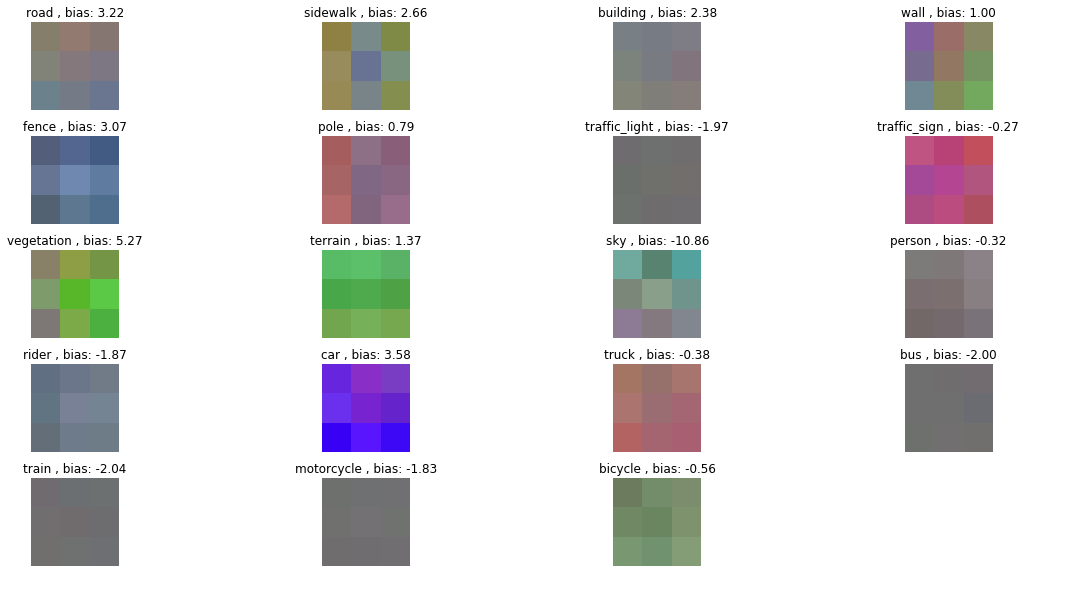

In [14]:
Sur.visualize_potentials(energy.operator, Sur.data.CityscapesSemantic.class_names, mode='rescale')

# Segmentation with perimeter term (alpha=1)

In [60]:
tv_setup = deepcopy(model_setup)
tv_setup['alpha'] = 1

In [16]:
energy = energy_setup(tv_setup)
optimizer = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm=algorithm)
optimizer.run();

status: iteration    0, loss: 3.10952 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 1.40680 (acc est: 52.22%), tol: 0.003%
status: iteration 2000, loss: 1.38415 (acc est: 52.99%), tol: 0.001%
status: iteration 3000, loss: 1.37410 (acc est: 53.33%), tol: 0.001%
status: iteration 4000, loss: 1.36611 (acc est: 53.60%), tol: 0.000%
status: iteration 5000, loss: 1.35995 (acc est: 53.81%), tol: 0.000%
status: iteration 6000, loss: 1.35538 (acc est: 53.97%), tol: 0.000%
status: finished  6701  iterations in 28 minutes and 45.58 seconds. tol: 0.000%


In [17]:
output, _ = training_error(energy, samples);
_, _ = metric_error(energy, samples);

TRAINING | NLLloss: 1.30592 | acc  for these samples: 53.53%%,  Time: 01:49 mins
TRAINEVAL| --------------   | acc  for these samples: 55.18%%,  Time: 01:16 mins


In [18]:
output_direct = energy.maximal_potential(samples.y)
metric, metric_n, metric_f = loss.metric(samples.x, output_direct, labels_given=True)
print(f'POTENTIALMAX| --------------| {metric_n} for these samples: {metric:{metric_f}}%')

POTENTIALMAX| --------------| acc  for these samples: 50.26%%


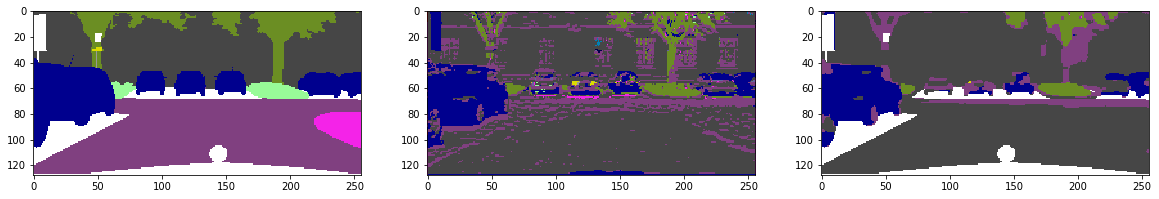

In [19]:
idx = 0
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(decode_img(samples.x[idx,:,:], energy.valid_pixels[idx, :,:]))
axes[1].imshow(Sur.data.CityscapesSemantic.decode_segmap(output_direct[idx,:,:].cpu().numpy()))
axes[2].imshow(decode_img(output[idx,:,:], energy.valid_pixels[idx,:,:]))
fig.canvas.draw()

Dictionary norm is 137.539.


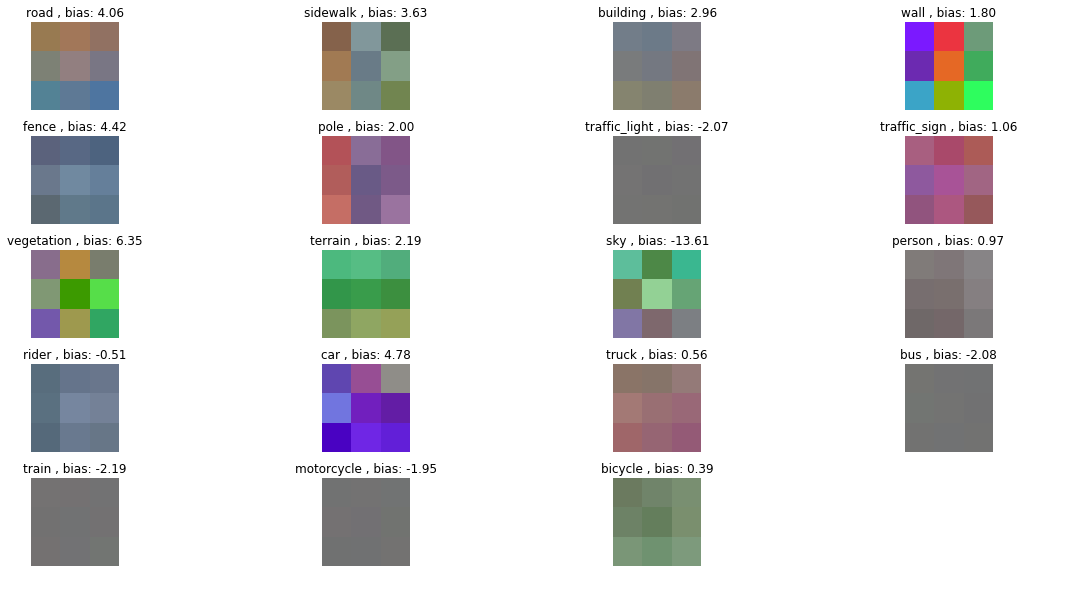

In [20]:
Sur.visualize_potentials(energy.operator, Sur.data.CityscapesSemantic.class_names, mode='rescale')

## Iterative

In [21]:
energy = energy_setup(tv_setup)

In [22]:
training_setup

{'lr': 0.01,
 'max_iterations': 8000,
 'min_iterations': 1,
 'loss_offset': 0,
 'tolerance': 1e-10,
 'algorithm': 'Adam',
 'correction': False,
 'callback': 1000,
 'validation': -1,
 'verbose': True,
 'L': 1,
 'inertia': 0}

In [ ]:
energy = energy_setup(tv_setup)

subroutine = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm='joint-dual')
iterative_setup = dict(linearizer_iterations=5, extrapolation_choice='theta-k', restart=False, 
                       output='best-metric', backtracking=False, check_loss=True, verbose=True,
                       tolerance=1e-9, stochastic=False)

optimizer =  Sur.training.IterativeLearning(subroutine, iterative_setup)
optimizer.run();

In [24]:
output, _ = training_error(energy, samples);
_, _ = metric_error(energy, samples);

TRAINING | NLLloss: 1.46964 | acc  for these samples: 57.63%%,  Time: 01:50 mins
TRAINEVAL| --------------   | acc  for these samples: 57.64%%,  Time: 01:18 mins


In [25]:
print(f'POTENTIALMAX| --------------| {metric_n} for these samples: {metric:{metric_f}}%')

POTENTIALMAX| --------------| acc  for these samples: 50.26%%


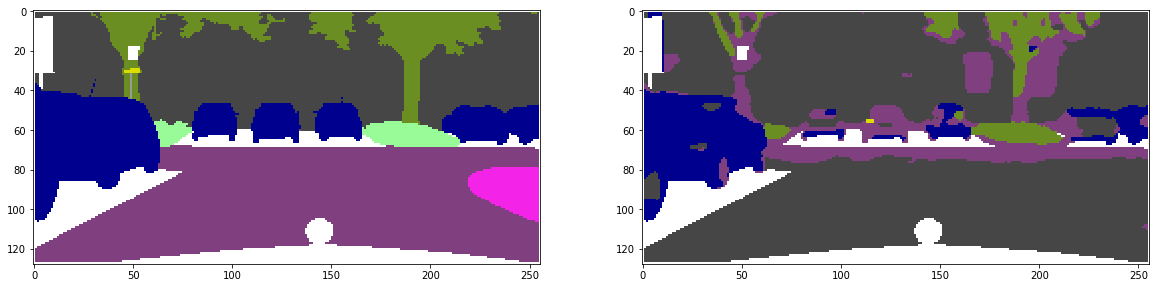

In [26]:
idx = 0
fig, axes = plt.subplots(1,2,figsize=(20, 10))
axes[0].imshow(decode_img(samples.x[idx,:,:], energy.valid_pixels[idx, :,:]))
axes[1].imshow(decode_img(output[idx,:,:], energy.valid_pixels[idx,:,:]))
fig.canvas.draw()

Dictionary norm is 149.097.


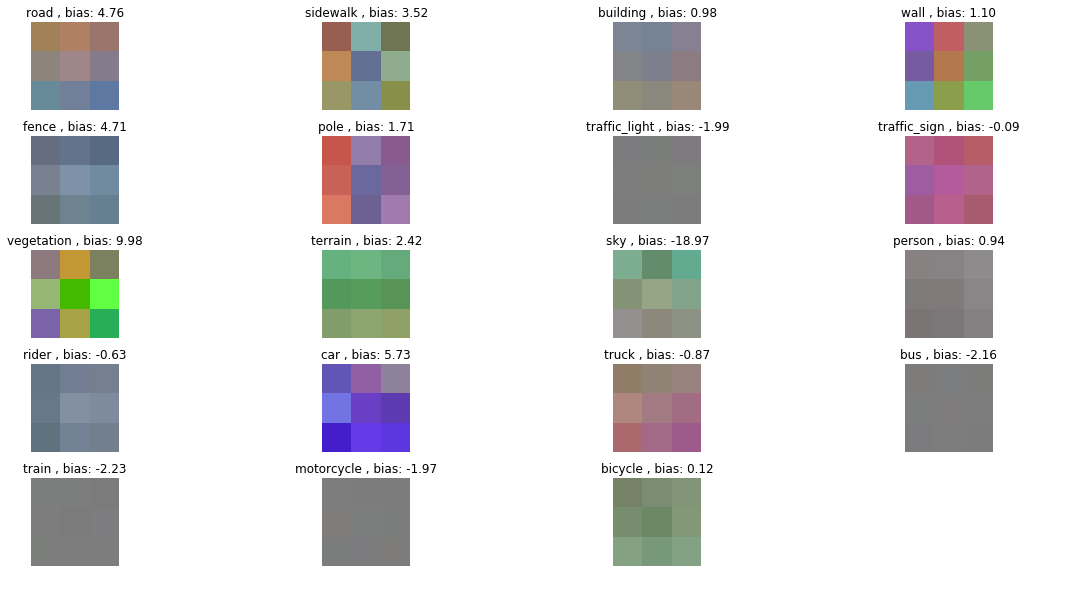

In [27]:
Sur.visualize_potentials(energy.operator, Sur.data.CityscapesSemantic.class_names, mode='rescale')

# WE_1

In [127]:
energy = energy_setup(tv_setup)

training_setup = Sur.training.default_setup('DiscriminativeLearning')
training_setup['lr'] = 0.01
training_setup['max_iterations'] = 8_000

optimizer = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm='W_E1')
optimizer.run();
output, _ = training_error(energy, samples);
_, _ = metric_error(energy, samples);

status: iteration    0, loss: 2.97193 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 1.37024 (acc est: 53.46%), tol: 0.003%
status: iteration 2000, loss: 1.35083 (acc est: 54.12%), tol: 0.001%
status: iteration 3000, loss: 1.34336 (acc est: 54.38%), tol: 0.000%
status: iteration 4000, loss: 1.33870 (acc est: 54.53%), tol: 0.000%
status: iteration 5000, loss: 1.33542 (acc est: 54.65%), tol: 0.000%
status: finished  5517  iterations in 29 minutes and 0.64 seconds. tol: 0.000%
TRAINING | NLLloss: 1.32374 | acc  for these samples: 49.92%%,  Time: 01:48 mins
TRAINEVAL| --------------   | acc  for these samples: 48.69%%,  Time: 01:18 mins


In [29]:
# subroutine = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm=algorithm)
# iterative_setup = dict(linearizer_iterations=5, extrapolation_choice='theta-k', restart=True, 
#                        output='best-metric', backtracking=False, check_loss=True, verbose=True,
#                        tolerance=1e-9, stochastic=False)

# optimizer =  Sur.training.IterativeLearning(subroutine, iterative_setup)
# optimizer.run();
# output, _ = training_error(energy, samples);
# _, _ = metric_error(energy, samples);

# Visualize progress

The following code repeats the previous experiments and computes accuracy at regular intervals.

In [30]:
energy = energy_setup(tv_setup)
training_setup = Sur.training.default_setup('DiscriminativeLearning')
training_setup['lr'] = 0.01
training_setup['max_iterations'] = 5000
training_setup['tolerance'] = -1
subroutine = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm='joint-dual')
subroutine.validation = 100
iterative_setup = dict(linearizer_iterations=5, extrapolation_choice='theta-k', restart=2, 
                       output='best-metric', backtracking=False, check_loss=True, verbose=True,
                       tolerance=1e-9, stochastic=False)

optimizer =  Sur.training.IterativeLearning(subroutine, iterative_setup)
optimizer.run();

status: iteration    0, loss: 3.21500 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 1.40798 (acc est: 52.18%), tol: 0.003%
status: iteration 2000, loss: 1.38524 (acc est: 52.95%), tol: 0.001%
status: iteration 3000, loss: 1.37520 (acc est: 53.29%), tol: 0.001%
status: iteration 4000, loss: 1.36763 (acc est: 53.55%), tol: 0.000%
status: finished  5000  iterations in 114 minutes and 7.29 seconds. tol: 0.000%
-- Iteration 0 done, tol: 100.000%, NLLloss: 1.31348, acc : 53.80%
status: iteration    0, loss: 5.41265 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 3.21755 (acc est: 5.26%), tol: 0.003%
status: iteration 2000, loss: 3.17971 (acc est: 5.26%), tol: 0.001%
status: iteration 3000, loss: 3.16960 (acc est: 5.26%), tol: 0.000%
status: iteration 4000, loss: 3.16408 (acc est: 5.26%), tol: 0.000%
status: finished  5000  iterations in 111 minutes and 56.86 seconds. tol: 0.000%
-- Iteration 1 done, tol: 3.751%, NLLloss: 1.36275, acc : 56.70%
status: iteration  

In [31]:
energy = energy_setup(model_setup)
optimizer_baseline = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, 'joint-dual')
optimizer_baseline.validation = 100
optimizer_baseline.run();

status: iteration    0, loss: 4.65620 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 3.03762 (acc est: 5.26%), tol: 0.001%
status: iteration 2000, loss: 3.02179 (acc est: 5.26%), tol: 0.000%
status: iteration 3000, loss: 3.01442 (acc est: 5.26%), tol: 0.000%
status: iteration 4000, loss: 3.00956 (acc est: 5.26%), tol: 0.000%
status: finished  5000  iterations in 20 minutes and 49.13 seconds. tol: 0.000%


In [117]:
%autoreload 2

energy = energy_setup(tv_setup)
algorithm = 'W_E1'

training_setup = Sur.training.default_setup('DiscriminativeLearning')
training_setup['lr'] = 0.1
training_setup['max_iterations'] = 5000
training_setup['tolerance'] = -1

optimizer_WE = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm='W_E1')
optimizer_WE.validation = 100
optimizer_WE.run();
output, _ = training_error(energy, samples);
_, _ = metric_error(energy, samples);

status: iteration    0, loss: 2.98357 (acc est: 5.26%), tol: 100.000%
status: iteration 1000, loss: 1.36956 (acc est: 53.49%), tol: 0.003%
status: iteration 2000, loss: 1.35126 (acc est: 54.11%), tol: 0.001%
status: iteration 3000, loss: 1.34387 (acc est: 54.36%), tol: 0.000%
status: iteration 4000, loss: 1.33857 (acc est: 54.54%), tol: 0.000%
status: finished  5000  iterations in 117 minutes and 49.54 seconds. tol: 0.000%
TRAINING | NLLloss: 1.32494 | acc  for these samples: 49.87%%,  Time: 01:48 mins
TRAINEVAL| --------------   | acc  for these samples: 48.78%%,  Time: 01:10 mins


In [123]:
x = list(range(0,training_setup['max_iterations']))
y_list = []
interval = optimizer.subroutine.stats['iterations'][0] // optimizer.subroutine.validation
iter_prev = 0
for iterations in optimizer.subroutine.stats['iterations']:
    y_list.append(optimizer.subroutine.stats['acc '][iter_prev:(iter_prev + interval)])
    iter_prev += interval
    
data = [go.Scatter(x=x, y=optimizer_baseline.stats['acc '][0:], name = 'Baseline')]
data.append(go.Scatter(x=x, y=optimizer_WE.stats['acc '][0:], name = f'Partial Surrogate'))
data.append(go.Scatter(x=x, y=y_list[0][0:], name = f'Bregman Surrogate'))
data.append(go.Scatter(x=x, y=y_list[1][0:], name = f'Iterative Surrogate, 1st iteration'))
data.append(go.Scatter(x=x, y=y_list[2][0:], name = f'Iterative Surrogate, 2nd iteration'))
data.append(go.Scatter(x=x, y=y_list[3][0:], name = f'Iterative Surrogate, 3rd iteration'))
data.append(go.Scatter(x=x, y=y_list[4][0:], name = f'Iterative Surrogate, 4th iteration'))

layout = go.Layout(
             autosize=False,
            showlegend=True,
             width=800,
             height=500,
             xaxis=dict(
                 type='log',
                 autorange=True,
                 title='Iterations',
                 ),
             yaxis=dict(
                 type='linear',
                 autorange = False,
                 range = [0.35, 0.65],
                 title='Accuracy',
             ),
               legend=dict(
                    x=0.0,
                    y=1.0,
                    traceorder='normal',
                    font=dict(
                        size=14,
                        color='#000'
                    ),
                    #bgcolor='#e6f3ff',
                    #iibordercolor='#FFFFFF',
                    borderwidth=2
                )
          )


fig = go.Figure(data=data, layout=layout)
ply.iplot(fig)

In [126]:
#pickle.dump(fig, open("figure_convex.pkl", "wb" ))
#fig = pickle.load( open("figure_convex.pkl", "rb" ) )
#pio.write_image(fig, 'convex_seg.pdf')